In [1]:
import os
import json

import numpy as np
import tensorflow as tf

from itertools import permutations

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
import wandb
from wandb.keras import WandbCallback

# 1. Start a new run
wandb.init(project='offline-rl', entity='deathn0t')

config = wandb.config
config.learning_rate = 0.01

wandb: Currently logged in as: cepedus (use `wandb login --relogin` to force relogin)
C:\Users\marti\AppData\Roaming\Python\Python36\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
# load the data

file_name = "polynome_ready_for_training.json"

with open(file_name, "r") as f:
    data = json.load(f)
    
print("keys: ", list(data.keys()))

keys:  ['states', 'actions', 'scores']


In [4]:
# keep only winning networks
X, y = [], []
n_networks = len(np.unique(data["actions"]))
n_func = len(data["states"]) // n_networks
# print(n_networks, n_func)
for f_i in range(n_func):
    best_network = None
    best_score = -2
    for n_i in range(n_networks):
        i = f_i * n_networks + n_i
        score = data["scores"][i]
        if score > best_score:
            best_score = score
            best_network = data["actions"][i]
    X.append(data["states"][i])
    y.append(best_network)

In [5]:
# Agressively augment data

new_samples = 10


len_X = len(X)
xy_lim = len(X[0])//2
for i in range(len_X):
    x_i = X[i]
    xx_i = x_i[:xy_lim]
    yy_i = x_i[xy_lim:]
    perms_i =[np.random.permutation(np.arange(xy_lim)) for _ in range(new_samples)]
    for p in list(perms_i):
        X.append([xx_i[j] for j in p]+[yy_i[j] for j in p])
        y.append(y[i])

In [6]:
X = np.array(X)
y = np.array(y)

# X = np.array(data["states"])
y = tf.keras.utils.to_categorical(y, len(np.unique(y)))

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (9900, 160)
y shape:  (9900, 5)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.33, 
    random_state=42
)

In [8]:
# Creation of the model

def generate_nn(input_shape, output_shape, nunits=[10, 10], activation=["relu", "relu"]):

    assert len(nunits) == len(activation)

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))

    for i, (nunits_, activation_) in enumerate(zip(nunits, activation)):
        model.add(
            tf.keras.layers.Dense(nunits_, activation=activation_, name=f"layer_{i+1}")
        )

    model.add(tf.keras.layers.Dense(output_shape, activation="softmax"))

    return model

nlayers = 3
config = dict(
    nunits=[100]*nlayers,
    activation=["relu"]*nlayers
)

model = generate_nn(X.shape[1:], y.shape[1], **config)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 100)               16100     
_________________________________________________________________
layer_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
layer_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense (Dense)                (None, 5)                 505       
Total params: 36,805
Trainable params: 36,805
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(
    optimizer="sgd",
    loss="categorical_crossentropy",
    metrics=["acc"]
)

history = model.fit(X_train, y_train, 
    epochs=100, 
    batch_size=16, 
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[WandbCallback()]
).history

Epoch 1/100
415/415 [==============================] - 1s 2ms/step - loss: 1.3557 - acc: 0.3451 - val_loss: 1.2099 - val_acc: 0.3777
Epoch 2/100
415/415 [==============================] - 1s 1ms/step - loss: 1.1942 - acc: 0.3855 - val_loss: 1.1975 - val_acc: 0.3927
Epoch 3/100
415/415 [==============================] - 1s 1ms/step - loss: 1.1831 - acc: 0.4196 - val_loss: 1.1916 - val_acc: 0.3976
Epoch 4/100
415/415 [==============================] - ETA: 0s - loss: 1.1532 - acc: 0.442 - 1s 1ms/step - loss: 1.1537 - acc: 0.4427 - val_loss: 1.1877 - val_acc: 0.4071
Epoch 5/100
415/415 [==============================] - 1s 1ms/step - loss: 1.1591 - acc: 0.4551 - val_loss: 1.1911 - val_acc: 0.4114
Epoch 6/100
415/415 [==============================] - 1s 1ms/step - loss: 1.1434 - acc: 0.4761 - val_loss: 1.1982 - val_acc: 0.4099
Epoch 7/100
415/415 [==============================] - 1s 1ms/step - loss: 1.1290 - acc: 0.4937 - val_loss: 1.1918 - val_acc: 0.4059
Epoch 8/100
415/415 [==========

415/415 [==============================] - 1s 1ms/step - loss: 0.0214 - acc: 0.9992 - val_loss: 5.3111 - val_acc: 0.3600
Epoch 61/100
415/415 [==============================] - 1s 1ms/step - loss: 0.0168 - acc: 0.9995 - val_loss: 5.3776 - val_acc: 0.3597
Epoch 62/100
415/415 [==============================] - 1s 1ms/step - loss: 0.0170 - acc: 0.9992 - val_loss: 5.4302 - val_acc: 0.3572
Epoch 63/100
415/415 [==============================] - 1s 1ms/step - loss: 0.0150 - acc: 0.9998 - val_loss: 5.4916 - val_acc: 0.3569
Epoch 64/100
415/415 [==============================] - 1s 1ms/step - loss: 0.0150 - acc: 0.9995 - val_loss: 5.5488 - val_acc: 0.3578
Epoch 65/100
415/415 [==============================] - 1s 1ms/step - loss: 0.0159 - acc: 0.9994 - val_loss: 5.5976 - val_acc: 0.3581
Epoch 66/100
415/415 [==============================] - 1s 2ms/step - loss: 0.0139 - acc: 0.9992 - val_loss: 5.6516 - val_acc: 0.3578
Epoch 67/100
415/415 [==============================] - 1s 1ms/step - loss:

<IPython.core.display.Javascript object>


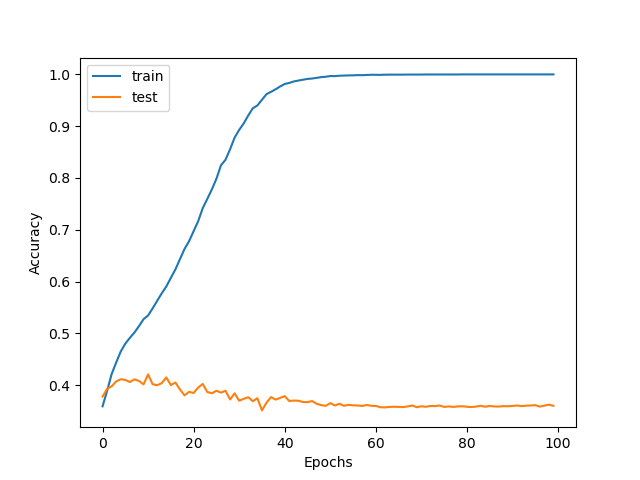

In [10]:
plt.figure()
plt.plot(history["acc"], label="train")
plt.plot(history["val_acc"], label="test")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

In [11]:
from sklearn import svm
from sklearn.metrics import accuracy_score

In [12]:
clf = svm.SVC(kernel="poly", gamma='auto')
clf.fit(X_train, np.argmax(y_train, axis=1))

SVC(gamma='auto', kernel='poly')

In [13]:
y_train_pred = clf.predict(X_train)
acc_train = accuracy_score(np.argmax(y_train, axis=1), y_train_pred)

y_pred = clf.predict(X_test)
acc_val = accuracy_score(np.argmax(y_test, axis=1), y_pred)

In [14]:
print(f'Train accuracy: {np.round(acc_train, 2)}\nTest accuracy: {np.round(acc_val, 2)}')

Train accuracy: 0.38
Test accuracy: 0.36


In [15]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [16]:
clf = PassiveAggressiveClassifier(max_iter=1000, random_state=0, tol=1e-3)
clf.fit(X_train, np.argmax(y_train, axis=1))

PassiveAggressiveClassifier(random_state=0)

In [17]:
y_train_pred = clf.predict(X_train)
acc_train = accuracy_score(np.argmax(y_train, axis=1), y_train_pred)

y_pred = clf.predict(X_test)
acc_val = accuracy_score(np.argmax(y_test, axis=1), y_pred)

In [18]:
print(f'Train accuracy: {np.round(acc_train, 2)}\nTest accuracy: {np.round(acc_val, 2)}')

Train accuracy: 0.32
Test accuracy: 0.3
